In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [39]:
class State(TypedDict):
    #Messages have the type "list". The "add Message functions"
    #in the annotation defines how this state key should be updated.
    #In  this case, it appends a message to the list, rather than overwriting it.
    messages: Annotated[list[str], add_messages]




In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

In [5]:
llm = ChatGroq(model = "llama3-8b-8192")

In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000256EC344C20>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000256EC3457F0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
def chatbot(state:State):
    #This function is called when the user sends a message.
    #It appends the message to the list of messages in the state.
    return {"messages":[llm.invoke(state["messages"])]}

In [8]:
graph_builder = StateGraph(State)
#Adding node to the graph
#The node is called "llmchatbot" and it uses the chatbot function.
graph_builder.add_node("llmchatbot",chatbot)

#Adding edges to the graph
#The START node is connected to the "llmchatbot" node.
graph_builder.add_edge(START, "llmchatbot")


#The "llmchatbot" node is connected to the END node.
graph_builder.add_edge("llmchatbot", END)

##Compile the graph
graph = graph_builder.compile()

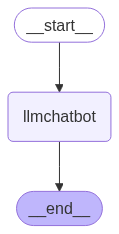

In [9]:
##Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [10]:
response = graph.invoke({"messages": "Hi, how are you?"})

In [11]:
response

{'messages': [HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='b5a2d799-675b-4c48-8e78-cd39f00cbaf8'),
  AIMessage(content="I'm just a language model, I don't have emotions or feelings like humans do, but I'm functioning properly and ready to help with any questions or tasks you may have! How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 16, 'total_tokens': 60, 'completion_time': 0.034834478, 'prompt_time': 0.002308907, 'queue_time': 0.26612885199999997, 'total_time': 0.037143385}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--41cf703a-9bd2-456e-9bcb-8e393944f511-0', usage_metadata={'input_tokens': 16, 'output_tokens': 44, 'total_tokens': 60})]}

In [12]:
response["messages"][-1].content

"I'm just a language model, I don't have emotions or feelings like humans do, but I'm functioning properly and ready to help with any questions or tasks you may have! How can I assist you today?"

In [13]:
load_dotenv()

True

# Chatbot with tool

In [14]:
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results=3)
res = tool.invoke("What is the capital of France?")

In [15]:
res["results"][1]["content"]

"Paris (French pronunciation: ⓘ) is the capital and largest city of France.With an estimated population of 2,048,472 residents in January 2025 [3] in an area of more than 105 km 2 (41 sq mi), [4] Paris is the fourth-most populous city in the European Union and the 30th most densely populated city in the world in 2022. [5] Since the 17th century, Paris has been one of the world's major centres"

In [16]:
##custom functions can be added to the graph
def multiply(a:int,b:int) -> int:
    """A simple function that multiplies two numbers.
    Args:
        a (int): The first number.
        b (int): The second number.
        Returns:
        int: The product of the two numbers."""
    return a * b

In [17]:
tools = [tool, multiply]

#Adding the tools to the graph
llm_with_tools = llm.bind_tools(tools)

In [18]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000256EC344C20>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000256EC3457F0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

In [22]:
## StateGraph with tools
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node Definition
def llm_calling_tool(state: State):
    return {
        "messages": [
            llm_with_tools.invoke(
                state["messages"]   
            )
        ]
    }

## Create a new StateGraph with the same state type
builder = StateGraph(State)
builder.add_node("llm_calling_tool",llm_calling_tool)
builder.add_node("tools",ToolNode(tools))

# Add edges to the graph
builder.add_edge(START, "llm_calling_tool")
builder.add_conditional_edges(
    "llm_calling_tool", # Call the LLM node
    # If the latest message (result) from the assistant is a tool call, -> tools_condition route to the tools node
    # If the latest message (result) from the assistant is not a tool call, -> END
    tools_condition  
)
builder.add_edge("tools", END)

# Compile the graph
graph_with_tools = builder.compile()


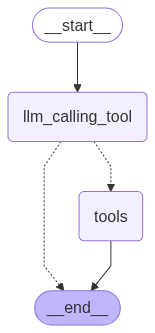

In [23]:
from IPython.display import Image, display
try:
    display(Image(graph_with_tools.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [24]:
graph_with_tools.invoke({"messages": "reent news on ai"})

{'messages': [HumanMessage(content='reent news on ai', additional_kwargs={}, response_metadata={}, id='39c3e996-7a6d-45ac-a45a-af16cf2737fc'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '3q52x9edz', 'function': {'arguments': '{"query":"recent news on AI","search_depth":"advanced","time_range":"day","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 2219, 'total_tokens': 2313, 'completion_time': 0.075203697, 'prompt_time': 0.246254223, 'queue_time': 0.269179072, 'total_time': 0.32145792}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8af39bf2ae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--38d7f2f8-f80c-4fd7-97c6-2d4b8ca7e50e-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'recent news on AI', 'search_depth': 'advanced', 'time_range': 'day', 'topic': 'general'}, 'id': '3q52x9edz', 'type': 'tool_call'}], usage_metadata={'input_tokens

In [25]:
response = graph_with_tools.invoke({"messages": "what is 5 multiplied by 6?"})

In [26]:
response

{'messages': [HumanMessage(content='what is 5 multiplied by 6?', additional_kwargs={}, response_metadata={}, id='182f070b-739a-464e-a6a1-4a489634578f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'b38yf77zy', 'function': {'arguments': '{"a":5,"b":6}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 2223, 'total_tokens': 2295, 'completion_time': 0.09258317, 'prompt_time': 0.247590666, 'queue_time': 0.27530866600000004, 'total_time': 0.340173836}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9c0ece94-0b5c-4f73-af45-96b3cfc79919-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 6}, 'id': 'b38yf77zy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2223, 'output_tokens': 72, 'total_tokens': 2295}),
  ToolMessage(content='30', name='multiply', id='cd0bb0b4-2d95-464b-b4f2-800682c3796f', tool_call_id

In [29]:
response = graph_with_tools.invoke({"messages": "what is the top trending news  what is 9 multiplied by 3 and ?"})

In [30]:
response

{'messages': [HumanMessage(content='what is the top trending news  what is 9 multiplied by 3 and ?', additional_kwargs={}, response_metadata={}, id='e045d75e-03cc-4109-8f7e-d20198afc83d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'zn5q5s5vv', 'function': {'arguments': '{"query":"top trending news"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'edfrh0gqx', 'function': {'arguments': '{"a":9,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 123, 'prompt_tokens': 2231, 'total_tokens': 2354, 'completion_time': 0.099229016, 'prompt_time': 0.247027245, 'queue_time': 0.26863958000000004, 'total_time': 0.346256261}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--686dcbb3-3ed3-42ce-9ab9-d19374c7eddd-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'top trending news'}, 'id': 'zn5q5s5vv', 'type': 'tool_call'}, {

In [31]:
response = graph_with_tools.invoke({"messages": "What is the news update on iran and israel and what is 5 multiply by5?"})

In [32]:
for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is the news update on iran and israel and what is 5 multiply by5?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (w2wbhzrxr)
 Call ID: w2wbhzrxr
  Args:
    query: latest news on iran and israel
    search_depth: advanced
    topic: news
  multiply (gmjqz1zzb)
 Call ID: gmjqz1zzb
  Args:
    a: 5
    b: 5
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news on iran and israel", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.understandingwar.org/backgrounder/iran-update-special-report-june-24-2025-morning-edition", "title": "Iran Update Special Report, June 24, 2025, Morning Edition - Institute for the Study of War", "score": 0.8003337, "published_date": "Tue, 24 Jun 2025 16:36:27 GMT", "content": "The ceasefire between Iran 

# Adding Memmory

In [33]:
## StateGraph with tools
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Node Definition
def llm_calling_tool(state: State):
    return {
        "messages": [
            llm_with_tools.invoke(
                state["messages"]   
            )
        ]
    }

## Create a new StateGraph with the same state type
builder = StateGraph(State)
builder.add_node("llm_calling_tool",llm_calling_tool)
builder.add_node("tools",ToolNode(tools))

# Add edges to the graph
builder.add_edge(START, "llm_calling_tool")
builder.add_conditional_edges(
    "llm_calling_tool", # Call the LLM node
    # If the latest message (result) from the assistant is a tool call, -> tools_condition route to the tools node
    # If the latest message (result) from the assistant is not a tool call, -> END
    tools_condition  
)
builder.add_edge("tools", END)

# Compile the graph
graph_with_tools = builder.compile(checkpointer=memory)


In [34]:
config = {"configurable":{"thread_id":"1"}}
response = graph_with_tools.invoke({"messages": "my name is jatindra paul"}, config=config)
response

{'messages': [HumanMessage(content='my name is jatindra paul', additional_kwargs={}, response_metadata={}, id='18b733d2-559d-4de7-a999-de38aa74659c'),
  AIMessage(content='Nice to meet you, Jatindra Paul!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 2222, 'total_tokens': 2234, 'completion_time': 0.02336613, 'prompt_time': 0.248313073, 'queue_time': 0.272746015, 'total_time': 0.271679203}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--e3fa3cc3-ac35-4867-8343-f57d64bb0f81-0', usage_metadata={'input_tokens': 2222, 'output_tokens': 12, 'total_tokens': 2234})]}

In [35]:
response["messages"][-1].content

'Nice to meet you, Jatindra Paul!'

In [36]:
response = graph_with_tools.invoke({"messages": "what is my name?"}, config=config)
response

{'messages': [HumanMessage(content='my name is jatindra paul', additional_kwargs={}, response_metadata={}, id='18b733d2-559d-4de7-a999-de38aa74659c'),
  AIMessage(content='Nice to meet you, Jatindra Paul!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 2222, 'total_tokens': 2234, 'completion_time': 0.02336613, 'prompt_time': 0.248313073, 'queue_time': 0.272746015, 'total_time': 0.271679203}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--e3fa3cc3-ac35-4867-8343-f57d64bb0f81-0', usage_metadata={'input_tokens': 2222, 'output_tokens': 12, 'total_tokens': 2234}),
  HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='236114a2-e25c-4ba2-a517-76491cdfcc40'),
  AIMessage(content='Your name is Jatindra Paul.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 2248, 'total_tokens': 2

In [37]:
response["messages"][-1].content

'Your name is Jatindra Paul.'

# Streaming

In [38]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [41]:
def superbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

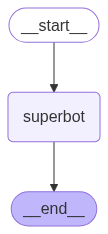

In [42]:
graph = StateGraph(State)

##node definition
graph.add_node("superbot", superbot)

# Add edges to the graph
graph.add_edge(START, "superbot")
graph.add_edge("superbot", END)

# Compile the graph with memory
graph_with_memory = graph.compile(checkpointer=memory)

##display the graph
from IPython.display import Image, display
try:
    display(Image(graph_with_memory.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [50]:
config = {"configurable":{"thread_id":"1"}}
response = graph_with_memory.invoke({"messages": "hey, my name is jatindra paul and i like basketball"}, config=config)
response

{'messages': [HumanMessage(content='hey, my name is jatindra paul and i like basketball', additional_kwargs={}, response_metadata={}, id='338474c0-8c11-4c24-94d8-068a183357bb'),
  AIMessage(content="Hey Jatindra Paul! Nice to meet you! That's awesome that you like basketball! What's your favorite team or player? Do you play basketball yourself or just enjoy watching it?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 24, 'total_tokens': 64, 'completion_time': 0.067617506, 'prompt_time': 0.012709303, 'queue_time': 0.716732554, 'total_time': 0.080326809}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--6d83c1f6-25fe-44f7-b2e3-27cea1397c41-0', usage_metadata={'input_tokens': 24, 'output_tokens': 40, 'total_tokens': 64}),
  HumanMessage(content='hey, my name is jatindra paul and i like basketball', additional_kwargs={}, response_metadata={}, id='ec7dc1a1-90bc-470

# Streaming
- Methods: stream() and astream()
    - these methods are sync and async methods for strweaming back results.

- Additional parameters in streaming modes for graph state
    - values: this streams the full state of the graph after each node is called.
    - updates: This streams updates to the state of the graph after each node is called.

In [53]:
#config = {"configurable":{"thread_id":"3"}}
for chunk in graph_with_memory.invoke({"messages": "hey, what sport i like"}, config=config,stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content='You like basketball!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 5, 'prompt_tokens': 311, 'total_tokens': 316, 'completion_time': 0.009872451, 'prompt_time': 0.164183365, 'queue_time': 0.47934517, 'total_time': 0.174055816}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--93a9a6c3-35b4-41f6-9a11-934f5eb18060-0', usage_metadata={'input_tokens': 311, 'output_tokens': 5, 'total_tokens': 316})]}}


In [57]:
#for values parameter
for chunk in graph_with_memory.stream({"messages": "hey, what is my name?"}, config=config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='hey, my name is jatindra paul and i like basketball', additional_kwargs={}, response_metadata={}, id='338474c0-8c11-4c24-94d8-068a183357bb'), AIMessage(content="Hey Jatindra Paul! Nice to meet you! That's awesome that you like basketball! What's your favorite team or player? Do you play basketball yourself or just enjoy watching it?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 24, 'total_tokens': 64, 'completion_time': 0.067617506, 'prompt_time': 0.012709303, 'queue_time': 0.716732554, 'total_time': 0.080326809}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--6d83c1f6-25fe-44f7-b2e3-27cea1397c41-0', usage_metadata={'input_tokens': 24, 'output_tokens': 40, 'total_tokens': 64}), HumanMessage(content='hey, my name is jatindra paul and i like basketball', additional_kwargs={}, response_metadata={}, id='ec7dc1a1-90bc-4703-b9

# Human in the loop

In [61]:
import os
from langchain.chat_models import init_chat_model
llm = init_chat_model(
    "groq:llama3-8b-8192",
    temperature=0.1,
    max_tokens=512,
    top_p=0.9,
    top_k=40,
    groq_api_key=os.getenv("GROQ_API_KEY"),
)
llm

d:\GenAi_project\AgenticAi_chatbot_using_tavily\.venv\Lib\site-packages\langchain_groq\chat_models.py:370: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(
d:\GenAi_project\AgenticAi_chatbot_using_tavily\.venv\Lib\site-packages\langchain_groq\chat_models.py:370: UserWarning: WARNING! top_k is not default parameter.
                    top_k was transferred to model_kwargs.
                    Please confirm that top_k is what you intended.
  warnings.warn(


ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000256EE539F90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000256EE53A990>, model_name='llama3-8b-8192', temperature=0.1, model_kwargs={'top_p': 0.9, 'top_k': 40}, groq_api_key=SecretStr('**********'), max_tokens=512)

In [ ]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list[str], add_messages]

graph = StateGraph(State)

@tool
def human_assistance(query: str,) -> str:
    """A tool to get request human assistance."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state:State):
    #This function is called when the user sends a message.
    #It appends the message to the list of messages in the state.
    message = [llm_with_tools.invoke(state["messages"])]

    return {"messages": [message]}

graph.add_node("chatbot", chatbot)

tool_node = ToolNode(tools)
graph.add_node("tools", tool_node)

# Add edges to the graph
graph.add_conditional_edges("chatbot")

